In [5]:
import Dataset_2019_2020 as dataset
from Train import train, plot_train_hist, set_seed_mps, Criterion
from Evaluate_multiclass import evaluate, probability_histogram
from torch import nn
import torch
import numpy as np
from Models_lesion import ResNet101Meta_19_20

## Binary Cross Entropy

In [2]:
# Load and Preprocess Data
# this is a single binary class setting! (Melanoma or not)
set_seed_mps(42)
train_transform, val_transform, test_transform = dataset.transforms(img_size=224)

train_ds = dataset.BCE_MelanomaDS_19_20.train(train_transform)
val_ds   = dataset.BCE_MelanomaDS_19_20.val(val_transform)
test_ds  = dataset.BCE_MelanomaDS_19_20.test(test_transform)
full_ds = dataset.BCE_MelanomaDS_19_20.full()
# sampler, pos_weight = dataset.multilabel_sampler(train_ds.df, train_ds.datacols)
# pos_weight = np.float32(pos_weight)

train_loader = dataset.DataLoader(train_ds, sampler=None, batch_size=64, shuffle=True, num_workers=4)
val_loader = dataset.DataLoader(val_ds, batch_size=64, num_workers=4)
test_loader = dataset.DataLoader(test_ds, batch_size=64, num_workers=4)

In [7]:
# Set up Model with binary cross entropy
net = ResNet101Meta_19_20(out_dim = 1)
net.to('mps')

pos_weight = torch.tensor(57*0.4, device = 'mps', dtype = torch.float32)
criterion = Criterion('binary', weights = pos_weight)
opt = torch.optim.AdamW([
    {"params": net.backbone.layer4.parameters(), "lr": 1e-5},
    {"params": net.head.parameters(), "lr": 1e-4}
])

# Train only the last layers (freeze the backbone)
for p in net.backbone.parameters():
    p.requires_grad = False
for p in net.backbone.layer4.parameters():
    p.requires_grad = True
for p in net.head.parameters():
    p.requires_grad = True

hist_train_loss_res, hist_val_loss_res, hist_val_acc_res = train(net, train_loader, val_loader, criterion, opt, epochs = 2, best_model_name = "best_BCE_Resnet101_meta_2019-20.pt")

In [11]:
x, y , m = next(iter(test_loader))
x , y,m = x.to('mps'),y.to('mps'),m.to('mps')
net(x).shape, y.shape

In [5]:
# Load Saved Model
net = ResNet101Meta_19_20(out_dim = 1)
net.to('mps')
state_dict = torch.load("best_BCE_Resnet101_meta_2019-20.pt", map_location='mps')
net.load_state_dict(state_dict)

acc, per_class_acc, auc_per_class, ys, ps  = evaluate(net, test_loader, device = 'mps', use_meta= True, threshold=0.5)

100%|██████████| 147/147 [03:38<00:00,  1.49s/it]

MEL: AUC=0.9177  ACC=0.7339
[[6368 2446]
 [  43  498]] 



In [3]:
# Load Saved Model
net = ResNet101Meta_19_20(out_dim = 1)
net.to('mps')
state_dict = torch.load("best_BCE_Resnet101_meta_2019-20.pt", map_location='mps')
net.load_state_dict(state_dict)

acc, per_class_acc, auc_per_class, ys, ps  = evaluate(net, test_loader, device = 'mps', use_meta= True, threshold=0.5)

100%|██████████| 147/147 [03:11<00:00,  1.30s/it]

MEL: AUC=0.9177  ACC=0.7339
[[6368 2446]
 [  43  498]] 



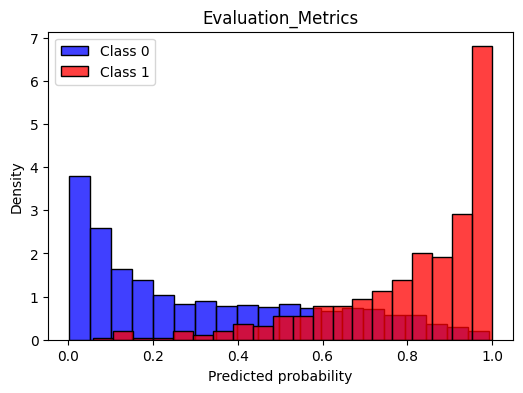

In [6]:
probability_histogram(ps, ys)

In [7]:
np.savez(
    "Training_metrics_2019-2020_BCE_resnet.npz",
    # EfficientNet2
    acc = acc, per_class_acc = per_class_acc, auc_per_class = auc_per_class, ys = ys, ps =ps)

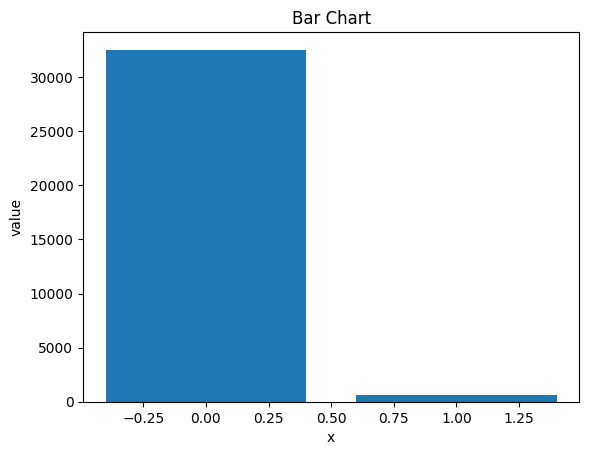

In [15]:
import matplotlib.pyplot as plt

x = [0, 1]
y = [32542, 584]

plt.bar(x, y)
plt.xlabel("x")
plt.ylabel("value")
plt.title("Bar Chart")
plt.show()

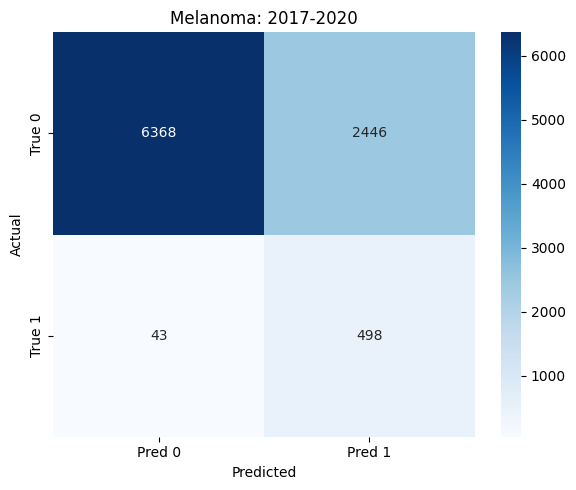

In [14]:
import seaborn as sns
import numpy as np

cm = np.array([[6368,2446]
 [  43 ,498]] )

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])

plt.title("Melanoma: 2017-2020")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [9]:
np.savez(
    "Training_metrics_2019-2020_BCE_resnet.npz",
    # EfficientNet2
    hist_train_loss =hist_train_loss_res,
    hist_val_loss =hist_val_loss_res,
    hist_val_acc =hist_val_acc_res)

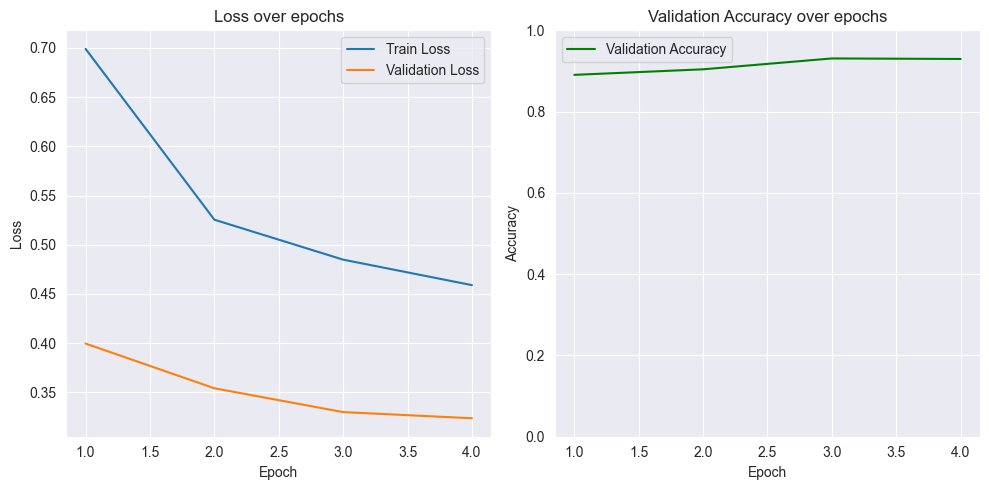

In [19]:
data = np.load("Training_metrics_2019-2020_BCE_resnet.npz", allow_pickle=True)
plot_train_hist(data['hist_train_loss'], data['hist_val_loss'], data['hist_val_acc'], epochs = 4)